In [308]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F 
import sklearn
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch.autograd import Variable
import pandas as pd
import os
from skimage import io, transform
import cv2
from IPython import embed

### TASK 1.  Develop and train a CVAE to encode and manipulate images in CelebA database.

In [309]:
dir = '/Users/tanishakhurana/Downloads/CelebA/list_attr_celeba.txt'

In [310]:
with open(dir, "r") as f:
    list_attr_celeba = f.read().splitlines()
    attribute_descriptions = list_attr_celeba[1]
    list_attr_celeba = list_attr_celeba[2:]

In [311]:
attribute_description_list = []
for elem in attribute_descriptions.split(' '):
    attribute_description_list.append(elem)


In [312]:
attribute_description_list.insert(0,'image_id')
attribute_description_list = attribute_description_list[:41]

In [313]:
list_attr_celeba = np.array(
            [[x for x in s.split()] for s in list_attr_celeba]
        )

In [63]:
list_attr_celeba.shape

(202599, 41)

In [314]:
list_attr_celeba = list_attr_celeba[:40000,:] #taking 40k for now

In [315]:
list_attr_celeba.shape    

(40000, 41)

In [316]:
df = pd.DataFrame(list_attr_celeba, columns=attribute_description_list)

In [317]:
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [318]:
list_attr_celeba = list_attr_celeba[:,1:]
list_attr_celeba = np.array([[int(y) for y in x] for x in list_attr_celeba])
list_attr_celeba

array([[-1,  1,  1, ..., -1, -1,  1],
       [-1, -1, -1, ..., -1, -1,  1],
       [-1, -1, -1, ..., -1, -1,  1],
       ...,
       [-1, -1,  1, ..., -1, -1,  1],
       [-1, -1, -1, ..., -1, -1,  1],
       [-1,  1,  1, ..., -1, -1,  1]])

In [319]:
list_attr_celeba.shape

(40000, 40)

In [320]:
class CelebA(Dataset):
    def __init__(self, root_dir,df, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,self.df.iloc[idx, 0])
        image = io.imread(img_name)
        attr = self.df.iloc[idx, 1:]
        attr = np.array([int(x) for x in attr])
        sample = {'image': image, 'attribute': attr}

        if self.transform:
            image = self.transform(sample['image'])
            sample = {'image': image, 'attribute': attr}
            

        return sample

In [321]:
root_dir='/Users/tanishakhurana/Downloads/CelebA/CelebA_40k/'
celeba_dataset = CelebA(root_dir, df)

In [322]:
sample = celeba_dataset[1]
sample['image'].shape

(218, 178, 3)

In [323]:
img, label = sample['image'], sample['attribute']

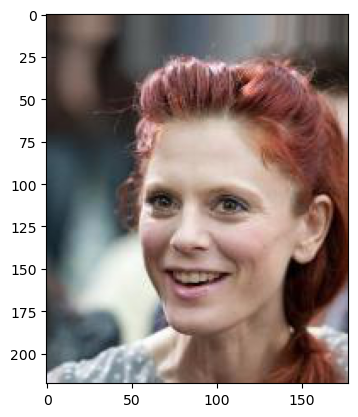

In [324]:
plt.imshow(img)

In [325]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5 ,0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])

In [326]:
celeb_transformed_dataset = CelebA(root_dir=root_dir,df = df,transform=transform)

In [327]:
sample = celeb_transformed_dataset[1]
img, label = sample['image'], sample['attribute']

In [328]:
img.shape

torch.Size([3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


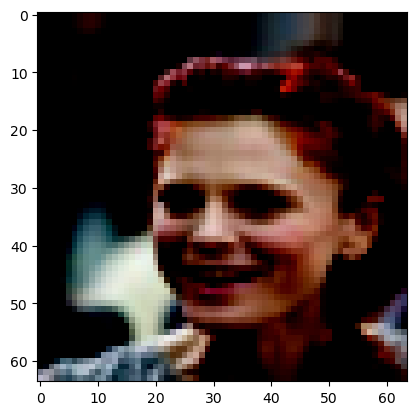

In [329]:
plt.imshow(img.permute(1, 2, 0))  #The shape convention for images used below is Channel x Height x Width.

In [330]:
class AttributeEncoder(nn.Module):      #4th dimension add for attribute
    def __init__(self):
        super(AttributeEncoder, self).__init__()
        self.fc = nn.Linear(40, 64*64)
        
    def forward(self, c):
        c = c.float()
        x = self.fc(c)
        x = x.view(-1, 64, 64)
        return x

In [331]:
attribute_encoder = AttributeEncoder()

In [332]:
tensor_label = torch.from_numpy(label)
print(tensor_label)

tensor([-1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,
        -1,  1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,
        -1, -1, -1,  1])


In [333]:
attr = attribute_encoder(tensor_label)
attr.shape

torch.Size([1, 64, 64])

In [334]:
img.shape

torch.Size([3, 64, 64])

In [335]:
image_with_attributes = torch.cat([img, attribute_encoder(tensor_label)], dim=0)

In [336]:
image_with_attributes.shape

torch.Size([4, 64, 64])

In [337]:
total_count = len(celeb_transformed_dataset)
total_count

40000

In [379]:
train_count = int(0.9 * total_count)     
val_count = int(0.05 * total_count)      
test_count = total_count - train_count - val_count    
celeb_train_dataset, celeb_val_dataset, celeb_test_dataset = torch.utils.data.random_split(
    celeb_transformed_dataset, (train_count, val_count, test_count))

In [380]:
len(celeb_train_dataset)

36000

In [381]:
len(celeb_val_dataset)

2000

In [382]:
len(celeb_test_dataset)

2000

In [383]:
celeb_train_dataloader = torch.utils.data.DataLoader(celeb_train_dataset,batch_size=1,shuffle=True)

In [384]:
celeb_val_dataloader = torch.utils.data.DataLoader(celeb_val_dataset,batch_size=1,shuffle=True)
celeb_test_dataloader = torch.utils.data.DataLoader(celeb_test_dataset,batch_size=1,shuffle=True)

In [385]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(40, 64*64) 
        # 5 conv layers 
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.fc_mu = nn.Linear(512 * 2 * 2, 128)        # latent dimension 128
        self.fc_logvar = nn.Linear(512 * 2 * 2, 128)
        
    def forward(self, x, c):      #give img -x and attributes -c 
        c = c.float()
        c = self.fc(c)
        c = c.view(-1,1, 64, 64)
        x = torch.cat([x, c], dim=1)    # concatenate attribute to image,  dim 1 because batch also there
        
        #5 leaky relu activations on conv layers
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        x = x.view(-1, 512 * 2 * 2)
        mu = self.fc_mu(x) 
        logvar = self.fc_logvar(x)
        return mu, logvar

In [386]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(128 + 40, 512 * 2 * 2)
        self.conv1 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv4 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv5 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=3,kernel_size=3, stride = 1, padding=1)
        
    def forward(self, z, c):
        
        x = torch.cat([z, c], dim=1)  #Concatenate the original attribute vector c to z.
        x = self.fc(x) #Pass this concatentaed vector to fully connected layer to get a vector of size 512x2x2.
        x = x.view(-1, 512, 2, 2)    #Reshape this output to shape [512,2,2]
        x = F.leaky_relu(self.conv1(x))      #([1, 256, 4, 4])
        x = F.leaky_relu(self.conv2(x))      #([1, 128, 8, 8])
        x = F.leaky_relu(self.conv3(x))      #([1, 64, 16, 16])
        x = F.leaky_relu(self.conv4(x))      #([1, 32, 32, 32])
        x = F.leaky_relu(self.conv5(x))      #([1, 32, 64 ,64])
        x = torch.tanh(self.conv6(x))        #([1, 3, 64, 64])
        return x

In [387]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()        #initialise encoder and decoder of VAE
        self.decoder = Decoder()
        
        #generate a random distribution w.r.t. the mu and log_var from the embedding space
    def reparameterize(self, mu, logvar): 
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)     #normal distribution with mean 0 and variance 1
        z = mu + epsilon * std
        return z
    
    def forward(self, x, c):
        mu, logvar = self.encoder(x, c)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decoder(z, c)
        return reconstruction, mu, logvar

In [388]:
model = VAE()
model


VAE(
  (encoder): Encoder(
    (fc): Linear(in_features=40, out_features=4096, bias=True)
    (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=2048, out_features=128, bias=True)
    (fc_logvar): Linear(in_features=2048, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=168, out_features=2048, bias=True)
    (conv1): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv3): ConvTranspose2d(128, 64, kernel_size=(3, 3),

In [389]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [390]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [391]:
model.train()

VAE(
  (encoder): Encoder(
    (fc): Linear(in_features=40, out_features=4096, bias=True)
    (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=2048, out_features=128, bias=True)
    (fc_logvar): Linear(in_features=2048, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=168, out_features=2048, bias=True)
    (conv1): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv3): ConvTranspose2d(128, 64, kernel_size=(3, 3),

In [392]:
num_epochs = 5
loss = 0
train_loss = 0
val_loss = 0

In [393]:
for epochs in range(num_epochs):
    for batch_idx, data in enumerate(celeb_train_dataloader):
        x = data['image'].to(device)
        c = data['attribute'].to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(x, c)
        loss = criterion(reconstruction, x)
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss += kl_divergence # reconstruction loss + kl divergence loss
        train_loss += loss
        loss.backward()
        optimizer.step()

        if (batch_idx +1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epochs +1, num_epochs, batch_idx +1, len(celeb_train_dataloader),loss))
            
    train_loss /= len(celeb_train_dataloader)
    print('Epoch {}, train_loss: {:.4f}'.format(epochs +1, train_loss))

Epoch [1/5], Step [100/36000], Loss: 0.5540
Epoch [1/5], Step [200/36000], Loss: 0.3220
Epoch [1/5], Step [300/36000], Loss: 0.2143
Epoch [1/5], Step [400/36000], Loss: 0.3627
Epoch [1/5], Step [500/36000], Loss: 0.6045
Epoch [1/5], Step [600/36000], Loss: 0.3527
Epoch [1/5], Step [700/36000], Loss: 0.6777
Epoch [1/5], Step [800/36000], Loss: 0.5860
Epoch [1/5], Step [900/36000], Loss: 0.4322
Epoch [1/5], Step [1000/36000], Loss: 0.2492
Epoch [1/5], Step [1100/36000], Loss: 0.4027
Epoch [1/5], Step [1200/36000], Loss: 0.1730
Epoch [1/5], Step [1300/36000], Loss: 0.1523
Epoch [1/5], Step [1400/36000], Loss: 0.3328
Epoch [1/5], Step [1500/36000], Loss: 0.2518
Epoch [1/5], Step [1600/36000], Loss: 0.1549
Epoch [1/5], Step [1700/36000], Loss: 0.7162
Epoch [1/5], Step [1800/36000], Loss: 0.1833
Epoch [1/5], Step [1900/36000], Loss: 0.3267
Epoch [1/5], Step [2000/36000], Loss: 0.1310
Epoch [1/5], Step [2100/36000], Loss: 0.1587
Epoch [1/5], Step [2200/36000], Loss: 0.2522
Epoch [1/5], Step [

Epoch [1/5], Step [18200/36000], Loss: 0.3294
Epoch [1/5], Step [18300/36000], Loss: 0.3580
Epoch [1/5], Step [18400/36000], Loss: 0.4929
Epoch [1/5], Step [18500/36000], Loss: 0.2881
Epoch [1/5], Step [18600/36000], Loss: 0.2954
Epoch [1/5], Step [18700/36000], Loss: 0.3116
Epoch [1/5], Step [18800/36000], Loss: 0.2439
Epoch [1/5], Step [18900/36000], Loss: 0.1226
Epoch [1/5], Step [19000/36000], Loss: 0.3019
Epoch [1/5], Step [19100/36000], Loss: 0.3356
Epoch [1/5], Step [19200/36000], Loss: 0.1764
Epoch [1/5], Step [19300/36000], Loss: 0.2444
Epoch [1/5], Step [19400/36000], Loss: 0.3547
Epoch [1/5], Step [19500/36000], Loss: 0.3258
Epoch [1/5], Step [19600/36000], Loss: 0.1941
Epoch [1/5], Step [19700/36000], Loss: 0.4910
Epoch [1/5], Step [19800/36000], Loss: 0.2053
Epoch [1/5], Step [19900/36000], Loss: 0.3798
Epoch [1/5], Step [20000/36000], Loss: 0.2142
Epoch [1/5], Step [20100/36000], Loss: 0.3736
Epoch [1/5], Step [20200/36000], Loss: 0.2032
Epoch [1/5], Step [20300/36000], L

Epoch [2/5], Step [100/36000], Loss: 0.1876
Epoch [2/5], Step [200/36000], Loss: 0.4817
Epoch [2/5], Step [300/36000], Loss: 0.0526
Epoch [2/5], Step [400/36000], Loss: 0.2646
Epoch [2/5], Step [500/36000], Loss: 0.1507
Epoch [2/5], Step [600/36000], Loss: 0.1530
Epoch [2/5], Step [700/36000], Loss: 0.3397
Epoch [2/5], Step [800/36000], Loss: 0.0798
Epoch [2/5], Step [900/36000], Loss: 0.2670
Epoch [2/5], Step [1000/36000], Loss: 0.6350
Epoch [2/5], Step [1100/36000], Loss: 0.5039
Epoch [2/5], Step [1200/36000], Loss: 0.0981
Epoch [2/5], Step [1300/36000], Loss: 0.4037
Epoch [2/5], Step [1400/36000], Loss: 0.2123
Epoch [2/5], Step [1500/36000], Loss: 0.2200
Epoch [2/5], Step [1600/36000], Loss: 0.2438
Epoch [2/5], Step [1700/36000], Loss: 0.2498
Epoch [2/5], Step [1800/36000], Loss: 0.2740
Epoch [2/5], Step [1900/36000], Loss: 0.1199
Epoch [2/5], Step [2000/36000], Loss: 0.1528
Epoch [2/5], Step [2100/36000], Loss: 0.1215
Epoch [2/5], Step [2200/36000], Loss: 0.1924
Epoch [2/5], Step [

Epoch [2/5], Step [18200/36000], Loss: 0.1518
Epoch [2/5], Step [18300/36000], Loss: 0.1980
Epoch [2/5], Step [18400/36000], Loss: 0.2229
Epoch [2/5], Step [18500/36000], Loss: 0.2463
Epoch [2/5], Step [18600/36000], Loss: 0.2092
Epoch [2/5], Step [18700/36000], Loss: 0.3202
Epoch [2/5], Step [18800/36000], Loss: 0.1752
Epoch [2/5], Step [18900/36000], Loss: 0.4275
Epoch [2/5], Step [19000/36000], Loss: 0.2477
Epoch [2/5], Step [19100/36000], Loss: 0.3517
Epoch [2/5], Step [19200/36000], Loss: 0.0977
Epoch [2/5], Step [19300/36000], Loss: 0.0757
Epoch [2/5], Step [19400/36000], Loss: 0.4006
Epoch [2/5], Step [19500/36000], Loss: 0.1381
Epoch [2/5], Step [19600/36000], Loss: 0.3747
Epoch [2/5], Step [19700/36000], Loss: 0.2441
Epoch [2/5], Step [19800/36000], Loss: 0.3484
Epoch [2/5], Step [19900/36000], Loss: 0.2395
Epoch [2/5], Step [20000/36000], Loss: 0.3986
Epoch [2/5], Step [20100/36000], Loss: 0.1599
Epoch [2/5], Step [20200/36000], Loss: 0.1833
Epoch [2/5], Step [20300/36000], L

Epoch [3/5], Step [100/36000], Loss: 0.2939
Epoch [3/5], Step [200/36000], Loss: 0.3718
Epoch [3/5], Step [300/36000], Loss: 0.4571
Epoch [3/5], Step [400/36000], Loss: 0.1913
Epoch [3/5], Step [500/36000], Loss: 0.1706
Epoch [3/5], Step [600/36000], Loss: 0.1996
Epoch [3/5], Step [700/36000], Loss: 0.3543
Epoch [3/5], Step [800/36000], Loss: 0.2244
Epoch [3/5], Step [900/36000], Loss: 0.3274
Epoch [3/5], Step [1000/36000], Loss: 0.2501
Epoch [3/5], Step [1100/36000], Loss: 0.4394
Epoch [3/5], Step [1200/36000], Loss: 0.3780
Epoch [3/5], Step [1300/36000], Loss: 0.3816
Epoch [3/5], Step [1400/36000], Loss: 0.2985
Epoch [3/5], Step [1500/36000], Loss: 0.3087
Epoch [3/5], Step [1600/36000], Loss: 0.1794
Epoch [3/5], Step [1700/36000], Loss: 0.2153
Epoch [3/5], Step [1800/36000], Loss: 0.3980
Epoch [3/5], Step [1900/36000], Loss: 0.3866
Epoch [3/5], Step [2000/36000], Loss: 0.1630
Epoch [3/5], Step [2100/36000], Loss: 0.2218
Epoch [3/5], Step [2200/36000], Loss: 0.1428
Epoch [3/5], Step [

Epoch [3/5], Step [18200/36000], Loss: 0.2025
Epoch [3/5], Step [18300/36000], Loss: 0.4451
Epoch [3/5], Step [18400/36000], Loss: 0.1620
Epoch [3/5], Step [18500/36000], Loss: 0.2831
Epoch [3/5], Step [18600/36000], Loss: 0.1971
Epoch [3/5], Step [18700/36000], Loss: 0.2467
Epoch [3/5], Step [18800/36000], Loss: 0.3802
Epoch [3/5], Step [18900/36000], Loss: 0.2027
Epoch [3/5], Step [19000/36000], Loss: 0.1900
Epoch [3/5], Step [19100/36000], Loss: 0.6208
Epoch [3/5], Step [19200/36000], Loss: 0.3215
Epoch [3/5], Step [19300/36000], Loss: 0.3306
Epoch [3/5], Step [19400/36000], Loss: 0.3239
Epoch [3/5], Step [19500/36000], Loss: 0.2696
Epoch [3/5], Step [19600/36000], Loss: 0.2932
Epoch [3/5], Step [19700/36000], Loss: 0.5185
Epoch [3/5], Step [19800/36000], Loss: 0.1605
Epoch [3/5], Step [19900/36000], Loss: 0.2371
Epoch [3/5], Step [20000/36000], Loss: 0.4741
Epoch [3/5], Step [20100/36000], Loss: 0.3047
Epoch [3/5], Step [20200/36000], Loss: 0.1420
Epoch [3/5], Step [20300/36000], L

Epoch [4/5], Step [100/36000], Loss: 0.2885
Epoch [4/5], Step [200/36000], Loss: 0.4698
Epoch [4/5], Step [300/36000], Loss: 0.3961
Epoch [4/5], Step [400/36000], Loss: 0.2326
Epoch [4/5], Step [500/36000], Loss: 0.4632
Epoch [4/5], Step [600/36000], Loss: 0.5469
Epoch [4/5], Step [700/36000], Loss: 0.4132
Epoch [4/5], Step [800/36000], Loss: 0.1848
Epoch [4/5], Step [900/36000], Loss: 0.5628
Epoch [4/5], Step [1000/36000], Loss: 0.3602
Epoch [4/5], Step [1100/36000], Loss: 0.1693
Epoch [4/5], Step [1200/36000], Loss: 0.1767
Epoch [4/5], Step [1300/36000], Loss: 0.3156
Epoch [4/5], Step [1400/36000], Loss: 0.1123
Epoch [4/5], Step [1500/36000], Loss: 0.1437
Epoch [4/5], Step [1600/36000], Loss: 0.2033
Epoch [4/5], Step [1700/36000], Loss: 0.1119
Epoch [4/5], Step [1800/36000], Loss: 0.4292
Epoch [4/5], Step [1900/36000], Loss: 0.2652
Epoch [4/5], Step [2000/36000], Loss: 0.1658
Epoch [4/5], Step [2100/36000], Loss: 0.2096
Epoch [4/5], Step [2200/36000], Loss: 0.5367
Epoch [4/5], Step [

Epoch [4/5], Step [18200/36000], Loss: 0.3378
Epoch [4/5], Step [18300/36000], Loss: 0.7347
Epoch [4/5], Step [18400/36000], Loss: 0.3515
Epoch [4/5], Step [18500/36000], Loss: 0.1512
Epoch [4/5], Step [18600/36000], Loss: 0.2194
Epoch [4/5], Step [18700/36000], Loss: 0.3317
Epoch [4/5], Step [18800/36000], Loss: 0.1271
Epoch [4/5], Step [18900/36000], Loss: 0.2084
Epoch [4/5], Step [19000/36000], Loss: 0.2670
Epoch [4/5], Step [19100/36000], Loss: 0.2322
Epoch [4/5], Step [19200/36000], Loss: 0.4123
Epoch [4/5], Step [19300/36000], Loss: 0.3834
Epoch [4/5], Step [19400/36000], Loss: 0.1614
Epoch [4/5], Step [19500/36000], Loss: 0.4474
Epoch [4/5], Step [19600/36000], Loss: 0.2518
Epoch [4/5], Step [19700/36000], Loss: 0.1783
Epoch [4/5], Step [19800/36000], Loss: 0.1920
Epoch [4/5], Step [19900/36000], Loss: 0.1737
Epoch [4/5], Step [20000/36000], Loss: 0.3227
Epoch [4/5], Step [20100/36000], Loss: 0.1961
Epoch [4/5], Step [20200/36000], Loss: 0.3515
Epoch [4/5], Step [20300/36000], L

Epoch [5/5], Step [100/36000], Loss: 0.3032
Epoch [5/5], Step [200/36000], Loss: 0.2182
Epoch [5/5], Step [300/36000], Loss: 0.1462
Epoch [5/5], Step [400/36000], Loss: 0.1729
Epoch [5/5], Step [500/36000], Loss: 0.4081
Epoch [5/5], Step [600/36000], Loss: 0.6480
Epoch [5/5], Step [700/36000], Loss: 0.2903
Epoch [5/5], Step [800/36000], Loss: 0.3006
Epoch [5/5], Step [900/36000], Loss: 0.1585
Epoch [5/5], Step [1000/36000], Loss: 0.3286
Epoch [5/5], Step [1100/36000], Loss: 0.5022
Epoch [5/5], Step [1200/36000], Loss: 0.1525
Epoch [5/5], Step [1300/36000], Loss: 0.2218
Epoch [5/5], Step [1400/36000], Loss: 0.4405
Epoch [5/5], Step [1500/36000], Loss: 0.2374
Epoch [5/5], Step [1600/36000], Loss: 0.3061
Epoch [5/5], Step [1700/36000], Loss: 0.2306
Epoch [5/5], Step [1800/36000], Loss: 0.5808
Epoch [5/5], Step [1900/36000], Loss: 0.1638
Epoch [5/5], Step [2000/36000], Loss: 0.1278
Epoch [5/5], Step [2100/36000], Loss: 0.1495
Epoch [5/5], Step [2200/36000], Loss: 0.3880
Epoch [5/5], Step [

Epoch [5/5], Step [18200/36000], Loss: 0.2803
Epoch [5/5], Step [18300/36000], Loss: 0.0900
Epoch [5/5], Step [18400/36000], Loss: 0.2242
Epoch [5/5], Step [18500/36000], Loss: 0.3372
Epoch [5/5], Step [18600/36000], Loss: 0.2095
Epoch [5/5], Step [18700/36000], Loss: 0.4029
Epoch [5/5], Step [18800/36000], Loss: 0.2935
Epoch [5/5], Step [18900/36000], Loss: 0.4784
Epoch [5/5], Step [19000/36000], Loss: 0.1523
Epoch [5/5], Step [19100/36000], Loss: 0.3569
Epoch [5/5], Step [19200/36000], Loss: 0.2165
Epoch [5/5], Step [19300/36000], Loss: 0.2264
Epoch [5/5], Step [19400/36000], Loss: 0.3252
Epoch [5/5], Step [19500/36000], Loss: 0.5001
Epoch [5/5], Step [19600/36000], Loss: 0.2826
Epoch [5/5], Step [19700/36000], Loss: 0.2538
Epoch [5/5], Step [19800/36000], Loss: 0.1810
Epoch [5/5], Step [19900/36000], Loss: 0.3823
Epoch [5/5], Step [20000/36000], Loss: 0.1789
Epoch [5/5], Step [20100/36000], Loss: 0.1645
Epoch [5/5], Step [20200/36000], Loss: 0.1339
Epoch [5/5], Step [20300/36000], L

In [394]:
torch.save(model.state_dict(), 'cvae_model_40k.pth')

In [409]:
model.eval()

with torch.no_grad():
    for epochs in range(num_epochs):    
        for batch_idx, data in enumerate(celeb_val_dataloader):
            x = data['image']
            c = data['attribute']
            recon_val, mu, logvar = model(x, c)
            loss = criterion(recon_val, x)
            kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss += kl_divergence
            val_loss += loss
        val_loss = val_loss / len(celeb_val_dataloader)

        print(f"Epoch [{epochs+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")

Epoch [1/5], Validation Loss: 0.3226
Epoch [2/5], Validation Loss: 0.2903
Epoch [3/5], Validation Loss: 0.2900
Epoch [4/5], Validation Loss: 0.2903
Epoch [5/5], Validation Loss: 0.2899


In [410]:
x.shape

torch.Size([1, 3, 64, 64])

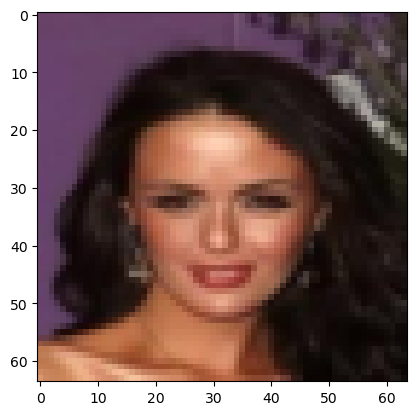

In [411]:
img_np = x.squeeze(0).permute(1, 2, 0).detach().numpy()

# Rescale values to range [0, 1]
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

# Display the image
plt.imshow(img_np)

In [412]:
img_np.shape

(64, 64, 3)

In [415]:
recon_val.shape

torch.Size([1, 3, 64, 64])

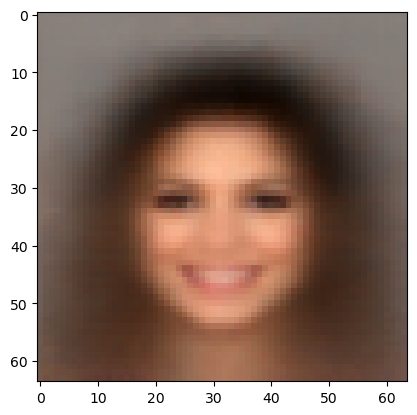

In [418]:
img_np = recon_val.squeeze(0).permute(1, 2, 0).detach().numpy()

# Rescale values to range [0, 1]
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

# Display the image
plt.imshow(img_np)

### TASK 2. Use the previusly trained CVAE to manipulate an image by changing the attribute vector input to the encoded image.

In [441]:
model.load_state_dict(torch.load('cvae_model_40k.pth'))

<All keys matched successfully>

In [478]:
sample = next(iter(celeb_test_dataloader))
img, label = sample['image'], sample['attribute']

In [479]:
img.shape

torch.Size([1, 3, 64, 64])

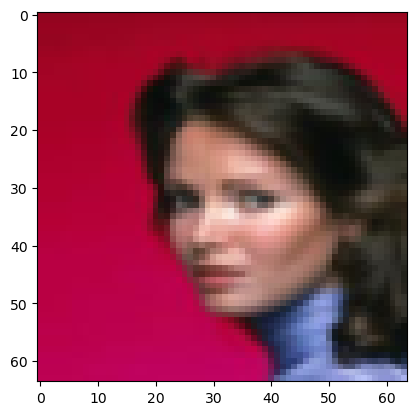

In [480]:
img_np = img.squeeze(0).permute(1, 2, 0).detach().numpy()

# Rescale values to range [0, 1]
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

# Display the image
plt.imshow(img_np)

In [481]:
mu,log_var = model.encoder(img,label)

In [482]:
label.shape

torch.Size([1, 40])

In [483]:
label

tensor([[-1, -1,  1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1,
          1, -1, -1,  1]])

In [484]:
attribute_description_list

['image_id',
 '5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Blurry',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'Narrow_Eyes',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young']

In [485]:
index = attribute_description_list.index('Smiling')
index = index -1 #image_id
index

31

In [486]:
label[:, 31]  # smiling attribute

tensor([-1])

In [487]:
new_attrs = torch.clone(label)
new_attrs

tensor([[-1, -1,  1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1,
          1, -1, -1,  1]])

In [488]:
new_attrs[:, 31] = 1

In [489]:
with torch.no_grad():
    z = model.reparameterize(mu, log_var)

In [490]:
z.shape

torch.Size([1, 128])

In [491]:
reconstruction = model.decoder(z,label)

In [492]:
reconstruction.shape

torch.Size([1, 3, 64, 64])

#### original reconstruction

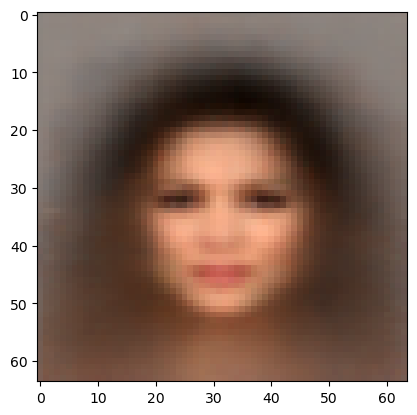

In [493]:
img_np = reconstruction.squeeze(0).permute(1, 2, 0).detach().numpy()

# Rescale values to range [0, 1]
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

# Display the image
plt.imshow(img_np)

### attribute changed reconstruction

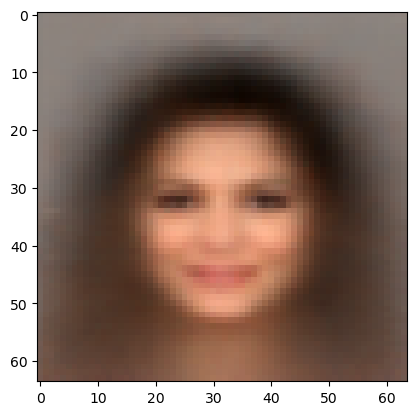

In [494]:
reconstruction = model.decoder(z,new_attrs)         # using new attributes
img_np = reconstruction.squeeze(0).permute(1, 2, 0).detach().numpy()

# Rescale values to range [0, 1]
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

# Display the image
plt.imshow(img_np)

### Mustache change

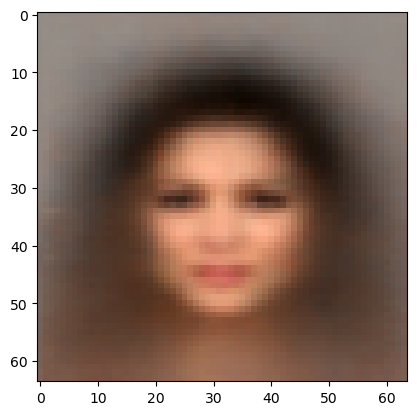

In [495]:
index = attribute_description_list.index('Mustache') -1
new_attrs = torch.clone(label)

new_attrs[:, index] = 1
reconstruction = model.decoder(z,new_attrs)
img_np = reconstruction.squeeze(0).permute(1, 2, 0).detach().numpy()

# Rescale values to range [0, 1]
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

# Display the image
plt.imshow(img_np)

### Glass wearing change


In [496]:
index = attribute_description_list.index('Eyeglasses') -1
label[:,index]

tensor([-1])

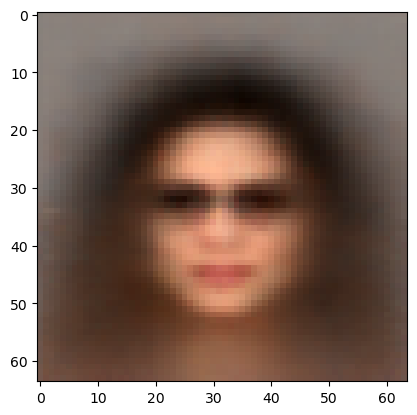

In [497]:
new_attrs = torch.clone(label)

new_attrs[:, index] = 1
reconstruction = model.decoder(z,new_attrs)
img_np = reconstruction.squeeze(0).permute(1, 2, 0).detach().numpy()

# Rescale values to range [0, 1]
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

# Display the image
plt.imshow(img_np)

### TASK 3. Slowly morph one image to another

In [507]:
sample_A = next(iter(celeb_test_dataloader))
img_A, label_A = sample_A['image'], sample_A['attribute']


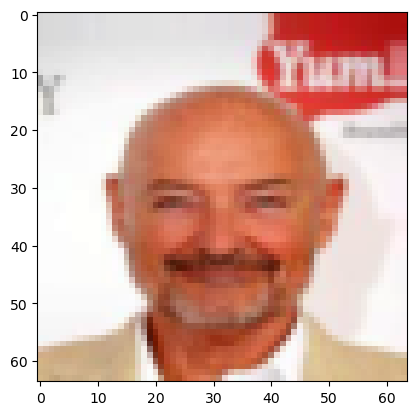

In [508]:
img_A_np = img_A.squeeze(0).permute(1, 2, 0).detach().numpy()

# Rescale values to range [0, 1]
img_A_np = (img_A_np - img_A_np.min()) / (img_A_np.max() - img_A_np.min())

# Display the image
plt.imshow(img_A_np)

In [509]:
sample_B = next(iter(celeb_test_dataloader))
img_B, label_B = sample_B['image'], sample_B['attribute']


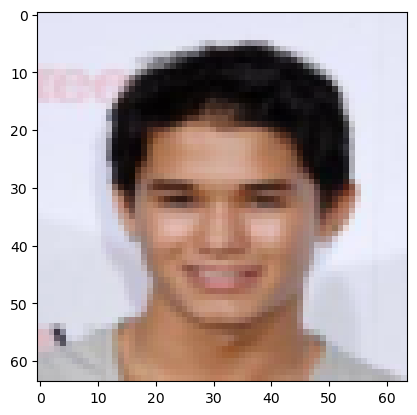

In [510]:
img_B_np = img_B.squeeze(0).permute(1, 2, 0).detach().numpy()

# Rescale values to range [0, 1]
img_B_np = (img_B_np - img_B_np.min()) / (img_B_np.max() - img_B_np.min())

# Display the image
plt.imshow(img_B_np)

In [511]:
img_A.shape

torch.Size([1, 3, 64, 64])

In [512]:
img_B.shape

torch.Size([1, 3, 64, 64])

In [513]:
label_A

tensor([[-1, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,
         -1,  1,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1,
         -1, -1, -1, -1]])

In [514]:
label_B

tensor([[-1, -1,  1,  1, -1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1,
         -1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1, -1, -1,  1,  1, -1,  1, -1,
         -1, -1, -1,  1]])

In [515]:
mu_A,log_var_A = model.encoder(img_A,label_A)
mu_B,log_var_B = model.encoder(img_B,label_B)

###  μA→B =(1−δ)·μA +δ·μB withδ∈(0,1)

In [516]:
delta = 0.2      #for interpolation

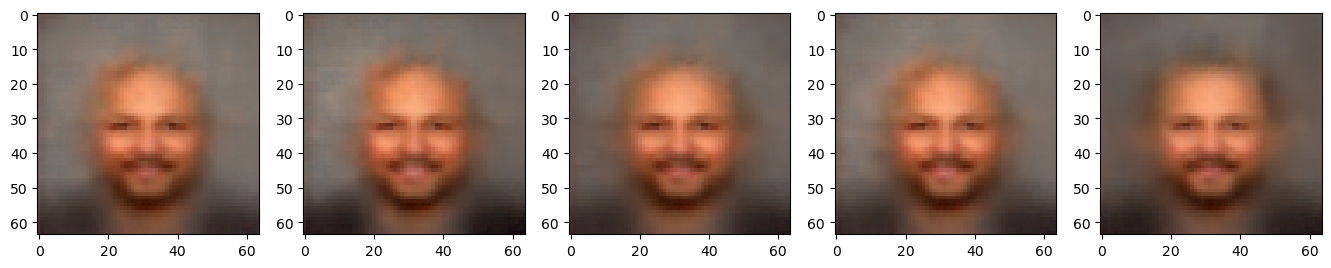

In [517]:
fig=plt.figure(figsize=(20, 10))
for i in range(1,6):
    mu_interp = (1 - delta) * mu_A + delta * mu_B
    z = model.reparameterize(mu_interp, log_var_A)
    with torch.no_grad():
        reconstruction = model.decoder(z,label_A)
    
    img_np = reconstruction.squeeze(0).permute(1, 2, 0).detach().numpy()

    # Rescale values to range [0, 1]
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    # Display the image
    fig.add_subplot(1, 6, i)
    plt.imshow(img_np)

    
    delta += 0.2
plt.show()  